# Modeling the motion of a golf ball



As an avid golfer I think it would be very interesting to model the motion of a golf ball and more importantly see how the parameters change the ball flight.

Also it would be interesting to see how spin effects my own ball's flight path.

### Let's first layout the general assumptions for this project
1) Overall the conditions and the set up to model the motion are very similar to the baseball we did in class. So first we can establish some constants many of which are the same from the baseball. 

2) To maximize simplicity of data and to easily validate our findings I will use the same launch angle (20 degrees) and velocity (60 m/s) as in *Computational Modeling and Visualization of Physical Systems* by Jay Wang.

3) Sidespin and ball movement from left to right will be negated as we only care to look at distance traveled and not accuracy.

4) Spinrate and spin should always be assumed as backspin unless otherwise stated.


In [1]:
import ode #imported from 02-02
import numpy as np
import matplotlib.pyplot as plt

### Constants

In [2]:
g = 9.8 #N/kg
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 43e-3/2 #43 mm diameter, 270mm in circumference
A = np.pi*r**2 #cross-sectional area
Cd =  0 #.25*(1+1/(1+np.exp(2*vmag0-12)))
m = 0.0459 #kg
b2 = 1/2*Cd*rho*A #will change as Cd changes

S = 0.01 #will change as omega and v change
CL = 0 #.55*(S**.4) #will change with S
alpha = 1/2*CL*rho*A*r/S


# New Cd and Cl values were given in 3.6.2

Lets first model the flight of a golf ball with no spin.

In [3]:
thetadeg = 20 #deg
vmag0 = 60 #m/s
theta = thetadeg*np.pi/180 #convert deg to rad

In [4]:
def quaddrag(d, t):
    """ Calculate and return the derivative of each quantity in an array d at the time t.
    
    Keyword arguments:
    t -- time at the beginning of the time step
    d -- an array of variables at time t
    """
    
    x = d[0]
    y = d[1]
    vx = d[2]
    vy = d[3]
    
    dxdt = vx
    dydt = vy
    
    v = np.sqrt(vx**2+vy**2)
    Cd =  .25*(1+1/(1+np.exp(2*v-12)))
    Fdragx = (-1/2)*Cd*rho*A*v**2 * vx/v
    Fdragy = (-1/2)*Cd*rho*A*v**2 * vy/v
    
    
    Fgravy = -m*g
    
    Fnetx = Fdragx
    Fnety = Fgravy + Fdragy
    
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    
    derivs = np.array([dxdt,dydt,dvxdt,dvydt])
    
    return derivs
    

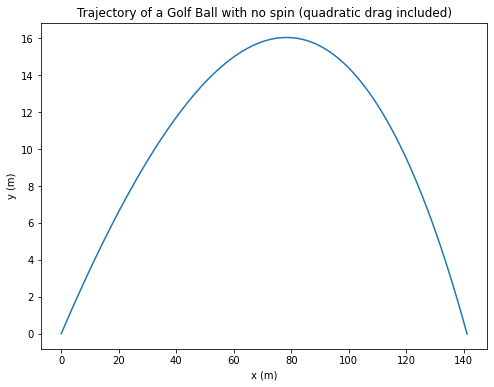

141.0914403474914


In [5]:
t = 0 #time in s
h = .01 #time step in s

# convert units and create initial conditions
theta = thetadeg*np.pi/180 #convert deg to rad

# initial position and velocity components
x = 0
y = 0

vx = vmag0*np.cos(theta)
vy = vmag0*np.sin(theta)

# lists for storing data to graph
tlist = []
xlist = []
ylist = []

# store initial values
tlist.append(t)
xlist.append(x)
ylist.append(y)

data = np.array([x,y,vx,vy])

# compute
while y >= 0:

    data = ode.RK4(quaddrag, data, t, h)
    t = t + h
    

    x = data[0]
    y = data[1]
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)

# Plot the trajectory
plt.figure(figsize = (8,6))
plt.title("Trajectory of a Golf Ball with no spin (quadratic drag included)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(xlist, ylist)
plt.show()

print(xlist[-1])

Lets add some spin to the ball and see its effects. The book uses spin rates of 8000 as normal and double that for high spin. With a bit of research we can see that even 8000rpm is VERY high so lets use some more accurate numbers. If we look at one of the leading companies in ball flight tracking technology we see that 2000-4000 spin rate is what 99% of players will exprience with a driver. [TrackMan](https://blog.trackmangolf.com/spin-rate/)

In [6]:
vmag0 = 78
thetadeg = 12.6
spinrate = 2060

# convert units and create initial conditions
theta = thetadeg*np.pi/180 #convert deg to rad


# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
omegax = 0
omegay = 0
omegaz = omegamag 

In [7]:
def magnus(d, t):
    """ Calculate and return the derivative of each quantity in an array d at the time t.
    
    Keyword arguments:
    t -- time at the beginning of the time step
    d -- an array of variables at time t
    """
    
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    dxdt = vx
    dydt = vy
    dzdt = vz
    
    v = np.sqrt(vx**2+vy**2+vz**2)
    Cd =  .25*(1+1/(1+np.exp(2*v-12)))
    Fdragx = (-1/2)*Cd*rho*A*v**2 * vx/v
    Fdragy = (-1/2)*Cd*rho*A*v**2 * vy/v
    Fdragz = (-1/2)*Cd*rho*A*v**2 * vz/v

    Fgravy = -m*g
    
    #magnus
    S = r*omegamag/v
    CL = 0.55*S**0.4
    alpha = 1/2*CL*rho*A*r/S
    Fmagnusx = alpha*(omegay*vz - omegaz*vy)
    Fmagnusy = alpha*(omegaz*vx - omegax*vz)
    Fmagnusz = alpha*(omegax*vy - omegay*vx)
    
    Fnetx = Fdragx + Fmagnusx
    Fnety = Fgravy + Fdragy + Fmagnusy
    Fnetz = Fdragz + Fmagnusz
    
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])
    
    return derivs

In [8]:
def simulate():
    t = 0 #time in s
    h = .01 #time step in s
    
    # initial position and velocity components
    x = 0
    y = 0
    z = 0
    vx = vmag0*np.cos(theta)
    vy = vmag0*np.sin(theta)
    vz = 0

    # array for instantaneous position and velocity data
    data = np.array([x, y, z, vx, vy, vz])


    # lists for storing data to graph
    tlist = []
    xlist = []
    ylist = []
    zlist = []

    # store initial values
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)

    # compute
    while y >= 0:

        data = ode.RK4(magnus, data, t, h)
        t = t + h

        x = data[0]
        y = data[1]
        z = data[2]
        tlist.append(t)
        xlist.append(x)
        ylist.append(y)
        zlist.append(z)

    # Plot the trajectory
    plt.figure(figsize = (8,6))
    plt.title("Trajectory of a Golf Ball with spin and quadratic drag ")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(xlist, ylist)
    plt.show()

    print("The carry of the golf ball with ",spinrate," rpm is:",xlist[-1])

### Lets test some real world data to our simulation

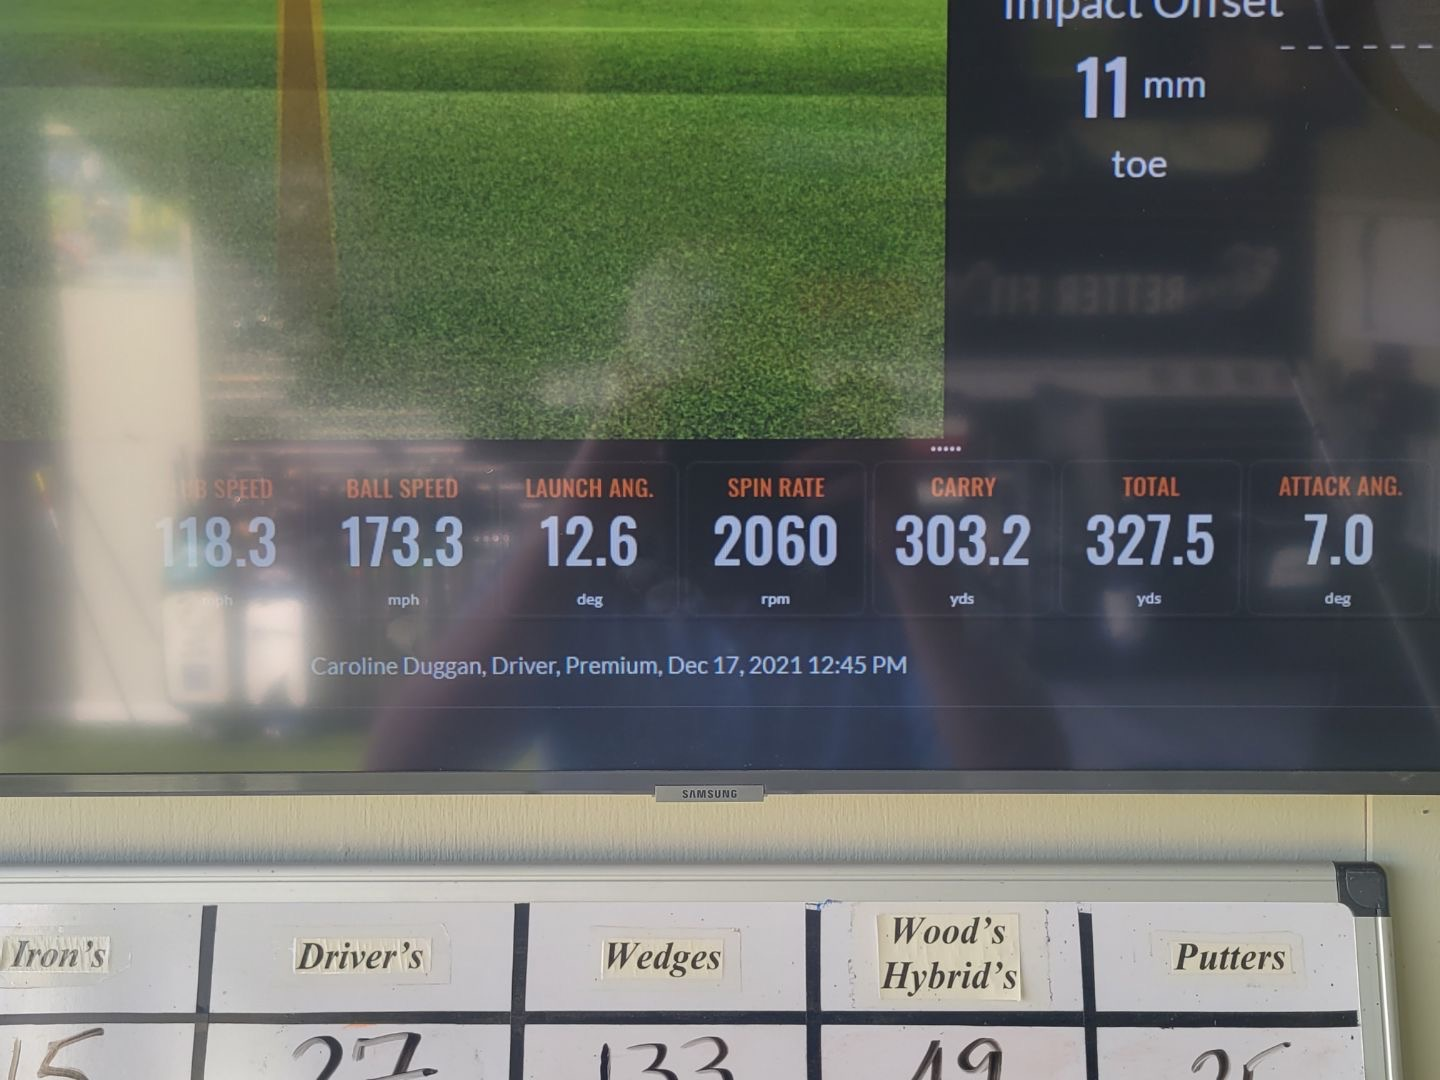

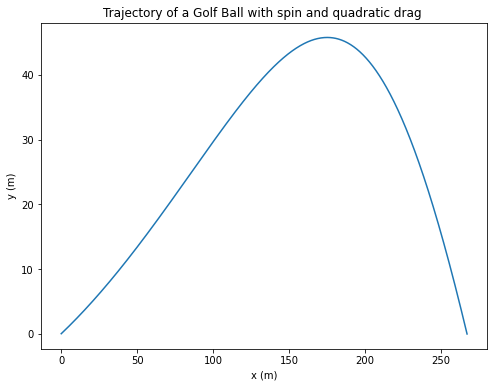

The carry of the golf ball with  2060  rpm is: 267.0262427082822
2060


In [9]:
simulate()


### Wow!
Thats a pretty large discrepancy. I do not know other factors that allowed that ball to travel that far so lets test some different data.

According to the graph below with a ball speed of 60 m/s the ball should travel ~240m. They appear to be using the same drag coefficient and lift coefficient as I am. Obviously this can be swayed by spin and the magnus effect but it gives us a good number to "shoot for".  [From here](https://www.golf-simulators.com/physics.htm)

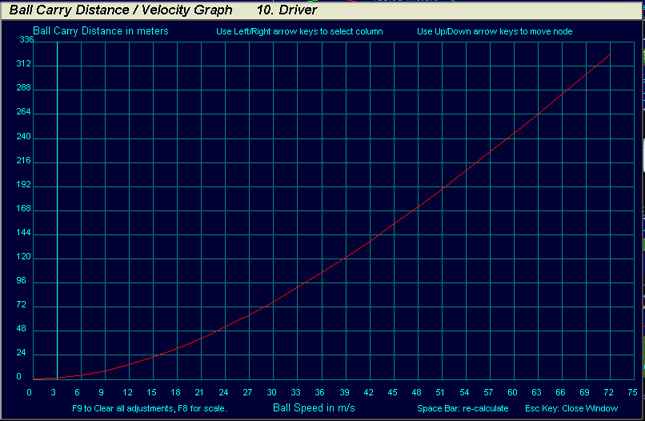

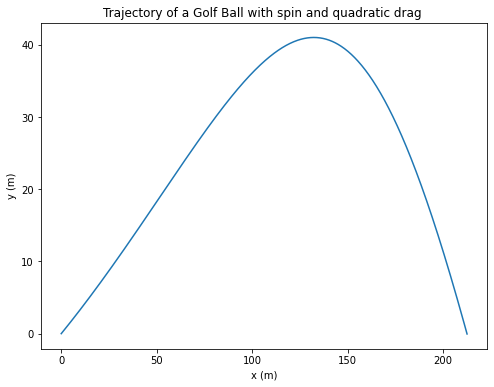

The carry of the golf ball with  3000  rpm is: 212.64322822035064


In [63]:
vmag0 = 60
thetadeg = 18
spinrate = 3000

# convert units and create initial conditions
theta = thetadeg*np.pi/180 #convert deg to rad


# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
omegax = 0
omegay = 0
omegaz = omegamag 


simulate()

Ok, so that doesnt seem to line up but on an important note it doesn't line up with the book either.

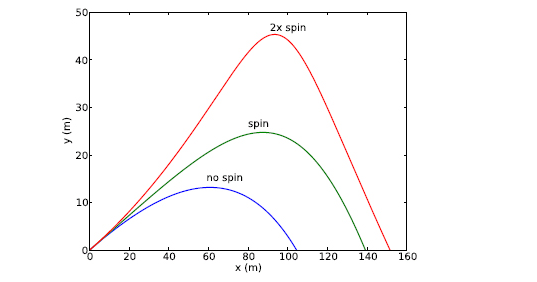

To reiterate, the book uses 60 m/s , 20 deg launch angle 8000 rpm for spin.

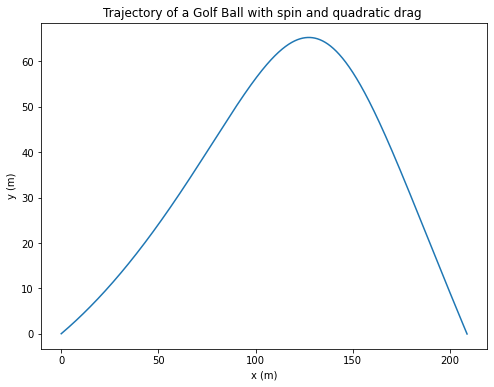

The carry of the golf ball with  8000  rpm is: 208.74083775534152


In [64]:
vmag0 = 60
thetadeg = 20
spinrate = 8000

# convert units and create initial conditions
theta = thetadeg*np.pi/180 #convert deg to rad


# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
omegax = 0
omegay = 0
omegaz = omegamag 
simulate()

#### We are over 60 meters away from the expected output! 
Now, I have some reservations about the book. It seems highly unlikely to me that a ball speed of 60 m/s (134 mph) could travel less than 150m. Even the  [Website](https://www.golf-simulators.com/physics.htm) from earlier backs up this assumption. Also these reservations are further fueled by the book using outrageous spin rates that no golfer could ever reach. It seems my simulation's trajectories sits somewhere between farther than the book but shorter than real life. 

In Conclusion my simulation seems to under predict the distance traveled in real life but over predict the distance when compared to the book. It is clear that the magnus effect is having an effect on the flight path as well as drag. Unfortunately I am unable to find my error in my calculations.